In [1]:
%matplotlib inline


Classifying Names with a Character-Level RNN
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <https://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Vietnamese.txt', 'data/names/English.txt', 'data/names/Greek.txt', 'data/names/Russian.txt', 'data/names/Spanish.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Portuguese.txt', 'data/names/French.txt', 'data/names/Polish.txt', 'data/names/Arabic.txt', 'data/names/German.txt', 'data/names/Scottish.txt', 'data/names/Czech.txt', 'data/names/Korean.txt', 'data/names/Irish.txt', 'data/names/Dutch.txt', 'data/names/Italian.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [3]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [4]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module (mostly copied from `the PyTorch for Torch users
tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__)
is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [6]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [7]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9339, -2.9699, -2.8587, -2.8676, -2.9536, -2.9396, -2.8167, -2.8930,
         -2.8773, -2.8474, -2.9759, -2.8841, -2.8556, -2.9096, -2.7699, -2.8568,
         -2.9309, -2.9116]], grad_fn=<LogSoftmaxBackward>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [8]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Korean', 14)


We will also want a quick way to get a training example (a name and its
language):




In [9]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Portuguese / line = Santos
category = Spanish / line = Rivero
category = Portuguese / line = Gomes
category = Japanese / line = Noro
category = French / line = Babineaux
category = Portuguese / line = Silva
category = Vietnamese / line = Luong
category = Scottish / line = Jones
category = Irish / line = Fionn
category = Japanese / line = Fuse


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [10]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [11]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [12]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 2.8085 Lucey / Dutch ✗ (English)
10000 10% (0m 10s) 2.0141 Rooiakkers / Greek ✗ (Dutch)
15000 15% (0m 15s) 1.9025 Raimondi / Russian ✗ (Italian)
20000 20% (0m 20s) 0.9281 Tahan / Arabic ✓
25000 25% (0m 25s) 2.6482 Bata / Japanese ✗ (Arabic)
30000 30% (0m 30s) 1.9025 Forrester / Scottish ✗ (English)
35000 35% (0m 35s) 0.9866 Mentis / Greek ✓
40000 40% (0m 40s) 0.7143 Sekigawa / Japanese ✓
45000 45% (0m 45s) 0.1090 Okawa / Japanese ✓
50000 50% (0m 50s) 0.3246 O'Hanlon / Irish ✓
55000 55% (0m 55s) 4.3355 Castillion / English ✗ (Spanish)
60000 60% (0m 59s) 0.0484 Cipriani / Italian ✓
65000 65% (1m 4s) 3.0058 Mozzis / Arabic ✗ (Czech)
70000 70% (1m 9s) 0.0637 O'Toole / Irish ✓
75000 75% (1m 14s) 0.3095 Escarcega / Spanish ✓
80000 80% (1m 19s) 0.7968 Jager / German ✓
85000 85% (1m 24s) 0.0637 Quyen / Vietnamese ✓
90000 90% (1m 29s) 0.4533 Youn / Korean ✓
95000 95% (1m 34s) 0.0682 Kwang  / Korean ✓
100000 100% (1m 39s) 2.6554 Porcher / German ✗ (French)


Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




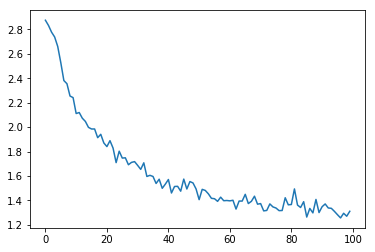

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




--- 0.0030236244201660156 seconds ---
--- 0.0032835006713867188 seconds ---
--- 0.0019478797912597656 seconds ---
--- 0.002699613571166992 seconds ---
--- 0.0013885498046875 seconds ---
--- 0.0026891231536865234 seconds ---
--- 0.001428365707397461 seconds ---
--- 0.002325773239135742 seconds ---
--- 0.002374410629272461 seconds ---
--- 0.002492189407348633 seconds ---
--- 0.004136562347412109 seconds ---
--- 0.002427816390991211 seconds ---
--- 0.0020041465759277344 seconds ---
--- 0.001684427261352539 seconds ---
--- 0.0014255046844482422 seconds ---
--- 0.0012049674987792969 seconds ---
--- 0.0011129379272460938 seconds ---
--- 0.0003337860107421875 seconds ---
--- 0.0003986358642578125 seconds ---
--- 0.00046133995056152344 seconds ---
--- 0.0003960132598876953 seconds ---
--- 0.00039696693420410156 seconds ---
--- 0.0003979206085205078 seconds ---
--- 0.00039386749267578125 seconds ---
--- 0.0005185604095458984 seconds ---
--- 0.00020766258239746094 seconds ---
--- 0.0004584789276

--- 0.0010502338409423828 seconds ---
--- 0.0010764598846435547 seconds ---
--- 0.00052642822265625 seconds ---
--- 0.0005254745483398438 seconds ---
--- 0.0003974437713623047 seconds ---
--- 0.00033855438232421875 seconds ---
--- 0.00040435791015625 seconds ---
--- 0.00014781951904296875 seconds ---
--- 0.0002741813659667969 seconds ---
--- 0.0005064010620117188 seconds ---
--- 0.00039839744567871094 seconds ---
--- 0.0005888938903808594 seconds ---
--- 0.0002751350402832031 seconds ---
--- 0.000335693359375 seconds ---
--- 0.00033974647521972656 seconds ---
--- 0.0002727508544921875 seconds ---
--- 0.00021028518676757812 seconds ---
--- 0.0004410743713378906 seconds ---
--- 0.00021004676818847656 seconds ---
--- 0.0005869865417480469 seconds ---
--- 0.0005993843078613281 seconds ---
--- 0.00033211708068847656 seconds ---
--- 0.0004630088806152344 seconds ---
--- 0.0007710456848144531 seconds ---
--- 0.0002722740173339844 seconds ---
--- 0.0004012584686279297 seconds ---
--- 0.0003397

--- 0.00057220458984375 seconds ---
--- 0.0007343292236328125 seconds ---
--- 0.0006949901580810547 seconds ---
--- 0.0005257129669189453 seconds ---
--- 0.0004611015319824219 seconds ---
--- 0.0006551742553710938 seconds ---
--- 0.000335693359375 seconds ---
--- 0.0002090930938720703 seconds ---
--- 0.0006499290466308594 seconds ---
--- 0.000522613525390625 seconds ---
--- 0.00046706199645996094 seconds ---
--- 0.0004589557647705078 seconds ---
--- 0.00020933151245117188 seconds ---
--- 0.00021123886108398438 seconds ---
--- 0.00029468536376953125 seconds ---
--- 0.0004818439483642578 seconds ---
--- 0.00033545494079589844 seconds ---
--- 0.00040841102600097656 seconds ---
--- 0.0007736682891845703 seconds ---
--- 0.0006520748138427734 seconds ---
--- 0.00021028518676757812 seconds ---
--- 0.0005230903625488281 seconds ---
--- 0.0004050731658935547 seconds ---
--- 0.0003962516784667969 seconds ---
--- 0.0005242824554443359 seconds ---
--- 0.0002696514129638672 seconds ---
--- 0.000334

--- 0.0008111000061035156 seconds ---
--- 0.0005509853363037109 seconds ---
--- 0.0006964206695556641 seconds ---
--- 0.0003826618194580078 seconds ---
--- 0.0004630088806152344 seconds ---
--- 0.0004646778106689453 seconds ---
--- 0.00033783912658691406 seconds ---
--- 0.0001461505889892578 seconds ---
--- 0.00025534629821777344 seconds ---
--- 0.0004241466522216797 seconds ---
--- 0.0004057884216308594 seconds ---
--- 0.0001456737518310547 seconds ---
--- 0.00022172927856445312 seconds ---
--- 0.0003383159637451172 seconds ---
--- 0.00038909912109375 seconds ---
--- 0.0007758140563964844 seconds ---
--- 0.0002110004425048828 seconds ---
--- 0.00028228759765625 seconds ---
--- 0.0005054473876953125 seconds ---
--- 0.0003991127014160156 seconds ---
--- 0.0005230903625488281 seconds ---
--- 0.0005278587341308594 seconds ---
--- 0.00033473968505859375 seconds ---
--- 0.00027632713317871094 seconds ---
--- 0.0004019737243652344 seconds ---
--- 0.0009000301361083984 seconds ---
--- 0.00027

--- 0.001995086669921875 seconds ---
--- 0.0004303455352783203 seconds ---
--- 0.00033593177795410156 seconds ---
--- 0.00046563148498535156 seconds ---
--- 0.0005240440368652344 seconds ---
--- 0.0003955364227294922 seconds ---
--- 0.00021600723266601562 seconds ---
--- 0.0005242824554443359 seconds ---
--- 0.00040268898010253906 seconds ---
--- 0.00014400482177734375 seconds ---
--- 0.00027370452880859375 seconds ---
--- 0.0007429122924804688 seconds ---
--- 0.00040340423583984375 seconds ---
--- 0.00027179718017578125 seconds ---
--- 0.00033283233642578125 seconds ---
--- 0.0005252361297607422 seconds ---
--- 0.0003979206085205078 seconds ---
--- 0.0004611015319824219 seconds ---
--- 0.00027108192443847656 seconds ---
--- 0.00027489662170410156 seconds ---
--- 0.00027370452880859375 seconds ---
--- 0.00039839744567871094 seconds ---
--- 0.0005242824554443359 seconds ---
--- 0.0005834102630615234 seconds ---
--- 0.00033211708068847656 seconds ---
--- 0.0004591941833496094 seconds ---

--- 0.0005466938018798828 seconds ---
--- 0.00045037269592285156 seconds ---
--- 0.0006597042083740234 seconds ---
--- 0.00032901763916015625 seconds ---
--- 0.0006361007690429688 seconds ---
--- 0.0004954338073730469 seconds ---
--- 0.0009255409240722656 seconds ---
--- 0.0004425048828125 seconds ---
--- 0.0002777576446533203 seconds ---
--- 0.000274658203125 seconds ---
--- 0.0005042552947998047 seconds ---
--- 0.0005030632019042969 seconds ---
--- 0.0006265640258789062 seconds ---
--- 0.00027251243591308594 seconds ---
--- 0.0004477500915527344 seconds ---
--- 0.0005946159362792969 seconds ---
--- 0.0006351470947265625 seconds ---
--- 0.0005869865417480469 seconds ---
--- 0.0006089210510253906 seconds ---
--- 0.0006256103515625 seconds ---
--- 0.0004000663757324219 seconds ---
--- 0.0003380775451660156 seconds ---
--- 0.0006494522094726562 seconds ---
--- 0.0005848407745361328 seconds ---
--- 0.00046515464782714844 seconds ---
--- 0.0005218982696533203 seconds ---
--- 0.000399351119

--- 0.0022852420806884766 seconds ---
--- 0.00027751922607421875 seconds ---
--- 0.00027441978454589844 seconds ---
--- 0.0006530284881591797 seconds ---
--- 0.0002732276916503906 seconds ---
--- 0.00034165382385253906 seconds ---
--- 0.0005311965942382812 seconds ---
--- 0.0003376007080078125 seconds ---
--- 0.0003387928009033203 seconds ---
--- 0.0001475811004638672 seconds ---
--- 0.0003981590270996094 seconds ---
--- 0.00027561187744140625 seconds ---
--- 0.00033402442932128906 seconds ---
--- 0.00040078163146972656 seconds ---
--- 0.00027298927307128906 seconds ---
--- 0.00046539306640625 seconds ---
--- 0.0005271434783935547 seconds ---
--- 0.00027370452880859375 seconds ---
--- 0.0003383159637451172 seconds ---
--- 0.0004725456237792969 seconds ---
--- 0.0003383159637451172 seconds ---
--- 0.0005924701690673828 seconds ---
--- 0.00046253204345703125 seconds ---
--- 0.0004608631134033203 seconds ---
--- 0.00027251243591308594 seconds ---
--- 0.0004019737243652344 seconds ---
--- 

--- 0.0019273757934570312 seconds ---
--- 0.0004756450653076172 seconds ---
--- 0.0004024505615234375 seconds ---
--- 0.0005257129669189453 seconds ---
--- 0.0004010200500488281 seconds ---
--- 0.0003998279571533203 seconds ---
--- 0.0006549358367919922 seconds ---
--- 0.00021028518676757812 seconds ---
--- 0.0003361701965332031 seconds ---
--- 0.0002770423889160156 seconds ---
--- 0.00052642822265625 seconds ---
--- 0.0005919933319091797 seconds ---
--- 0.00039887428283691406 seconds ---
--- 0.0002181529998779297 seconds ---
--- 0.0005295276641845703 seconds ---
--- 0.0003364086151123047 seconds ---
--- 0.0002739429473876953 seconds ---
--- 0.0002117156982421875 seconds ---
--- 0.0008170604705810547 seconds ---
--- 0.0004124641418457031 seconds ---
--- 0.00033473968505859375 seconds ---
--- 0.00014781951904296875 seconds ---
--- 0.0003178119659423828 seconds ---
--- 0.0004856586456298828 seconds ---
--- 0.0003380775451660156 seconds ---
--- 0.00027441978454589844 seconds ---
--- 0.000

--- 0.0005979537963867188 seconds ---
--- 0.0010912418365478516 seconds ---
--- 0.0003342628479003906 seconds ---
--- 0.0004634857177734375 seconds ---
--- 0.0003383159637451172 seconds ---
--- 0.0004646778106689453 seconds ---
--- 0.0003230571746826172 seconds ---
--- 0.000274658203125 seconds ---
--- 0.0007112026214599609 seconds ---
--- 0.0002722740173339844 seconds ---
--- 0.00039768218994140625 seconds ---
--- 0.000461578369140625 seconds ---
--- 0.0006470680236816406 seconds ---
--- 0.0006501674652099609 seconds ---
--- 0.00039458274841308594 seconds ---
--- 0.0002732276916503906 seconds ---
--- 0.00034308433532714844 seconds ---
--- 0.0005254745483398438 seconds ---
--- 0.0007064342498779297 seconds ---
--- 0.0005841255187988281 seconds ---
--- 0.0005819797515869141 seconds ---
--- 0.0004050731658935547 seconds ---
--- 0.0002727508544921875 seconds ---
--- 0.0004611015319824219 seconds ---
--- 0.000335693359375 seconds ---
--- 0.00046181678771972656 seconds ---
--- 0.00033402442

--- 0.001867055892944336 seconds ---
--- 0.0006482601165771484 seconds ---
--- 0.0002117156982421875 seconds ---
--- 0.00040149688720703125 seconds ---
--- 0.00039958953857421875 seconds ---
--- 0.0005924701690673828 seconds ---
--- 0.00040268898010253906 seconds ---
--- 0.00046896934509277344 seconds ---
--- 0.00040078163146972656 seconds ---
--- 0.0004630088806152344 seconds ---
--- 0.00046253204345703125 seconds ---
--- 0.0005233287811279297 seconds ---
--- 0.0007147789001464844 seconds ---
--- 0.0005896091461181641 seconds ---
--- 0.00040149688720703125 seconds ---
--- 0.0003459453582763672 seconds ---
--- 0.000213623046875 seconds ---
--- 0.0003371238708496094 seconds ---
--- 0.0002758502960205078 seconds ---
--- 0.0005352497100830078 seconds ---
--- 0.0005648136138916016 seconds ---
--- 0.0003991127014160156 seconds ---
--- 0.0004649162292480469 seconds ---
--- 0.0004627704620361328 seconds ---
--- 0.0003437995910644531 seconds ---
--- 0.0004630088806152344 seconds ---
--- 0.0003

--- 0.0021979808807373047 seconds ---
--- 0.0004239082336425781 seconds ---
--- 0.0005340576171875 seconds ---
--- 0.00027370452880859375 seconds ---
--- 0.00027370452880859375 seconds ---
--- 0.0004012584686279297 seconds ---
--- 0.0003352165222167969 seconds ---
--- 0.0007073879241943359 seconds ---
--- 0.000400543212890625 seconds ---
--- 0.0003974437713623047 seconds ---
--- 0.0006458759307861328 seconds ---
--- 0.0007731914520263672 seconds ---
--- 0.0002086162567138672 seconds ---
--- 0.0002722740173339844 seconds ---
--- 0.0001938343048095703 seconds ---
--- 0.00029730796813964844 seconds ---
--- 0.0005893707275390625 seconds ---
--- 0.0005221366882324219 seconds ---
--- 0.00027108192443847656 seconds ---
--- 0.0005002021789550781 seconds ---
--- 0.0005915164947509766 seconds ---
--- 0.0003349781036376953 seconds ---
--- 0.00033545494079589844 seconds ---
--- 0.0003323554992675781 seconds ---
--- 0.0004620552062988281 seconds ---
--- 0.0005223751068115234 seconds ---
--- 0.00059

--- 0.0013844966888427734 seconds ---
--- 0.0005450248718261719 seconds ---
--- 0.0005326271057128906 seconds ---
--- 0.0004622936248779297 seconds ---
--- 0.0005335807800292969 seconds ---
--- 0.0002810955047607422 seconds ---
--- 0.00046706199645996094 seconds ---
--- 0.00027561187744140625 seconds ---
--- 0.00033664703369140625 seconds ---
--- 0.000591278076171875 seconds ---
--- 0.00046706199645996094 seconds ---
--- 0.00028204917907714844 seconds ---
--- 0.0004611015319824219 seconds ---
--- 0.000461578369140625 seconds ---
--- 0.0005223751068115234 seconds ---
--- 0.0007638931274414062 seconds ---
--- 0.0005300045013427734 seconds ---
--- 0.00027489662170410156 seconds ---
--- 0.000400543212890625 seconds ---
--- 0.00039958953857421875 seconds ---
--- 0.0003376007080078125 seconds ---
--- 0.0003991127014160156 seconds ---
--- 0.00034332275390625 seconds ---
--- 0.0002732276916503906 seconds ---
--- 0.00046515464782714844 seconds ---
--- 0.00027680397033691406 seconds ---
--- 0.00

--- 0.00176239013671875 seconds ---
--- 0.0004019737243652344 seconds ---
--- 0.00044608116149902344 seconds ---
--- 0.0004372596740722656 seconds ---
--- 0.000492095947265625 seconds ---
--- 0.0004341602325439453 seconds ---
--- 0.0002758502960205078 seconds ---
--- 0.00040268898010253906 seconds ---
--- 0.00034546852111816406 seconds ---
--- 0.0005857944488525391 seconds ---
--- 0.0004019737243652344 seconds ---
--- 0.0002732276916503906 seconds ---
--- 0.00021195411682128906 seconds ---
--- 0.0006525516510009766 seconds ---
--- 0.0007243156433105469 seconds ---
--- 0.0006451606750488281 seconds ---
--- 0.00046539306640625 seconds ---
--- 0.0005896091461181641 seconds ---
--- 0.00027441978454589844 seconds ---
--- 0.0003600120544433594 seconds ---
--- 0.0005316734313964844 seconds ---
--- 0.00027060508728027344 seconds ---
--- 0.00033736228942871094 seconds ---
--- 0.00027370452880859375 seconds ---
--- 0.0007112026214599609 seconds ---
--- 0.00046825408935546875 seconds ---
--- 0.00

--- 0.0016744136810302734 seconds ---
--- 0.0004711151123046875 seconds ---
--- 0.0005934238433837891 seconds ---
--- 0.0002715587615966797 seconds ---
--- 0.0004718303680419922 seconds ---
--- 0.00040030479431152344 seconds ---
--- 0.0004608631134033203 seconds ---
--- 0.0006504058837890625 seconds ---
--- 0.000396728515625 seconds ---
--- 0.000396728515625 seconds ---
--- 0.0003387928009033203 seconds ---
--- 0.00039958953857421875 seconds ---
--- 0.0007178783416748047 seconds ---
--- 0.0003991127014160156 seconds ---
--- 0.0005869865417480469 seconds ---
--- 0.0004067420959472656 seconds ---
--- 0.0003986358642578125 seconds ---
--- 0.00033736228942871094 seconds ---
--- 0.00020933151245117188 seconds ---
--- 0.00039887428283691406 seconds ---
--- 0.0002772808074951172 seconds ---
--- 0.00040030479431152344 seconds ---
--- 0.0005905628204345703 seconds ---
--- 0.0003972053527832031 seconds ---
--- 0.0004608631134033203 seconds ---
--- 0.0003342628479003906 seconds ---
--- 0.00052380

--- 0.002202749252319336 seconds ---
--- 0.000213623046875 seconds ---
--- 0.0004057884216308594 seconds ---
--- 0.0004038810729980469 seconds ---
--- 0.00033664703369140625 seconds ---
--- 0.0004000663757324219 seconds ---
--- 0.0002722740173339844 seconds ---
--- 0.00047087669372558594 seconds ---
--- 0.00027489662170410156 seconds ---
--- 0.0005266666412353516 seconds ---
--- 0.00021076202392578125 seconds ---
--- 0.0003998279571533203 seconds ---
--- 0.0002110004425048828 seconds ---
--- 0.0006551742553710938 seconds ---
--- 0.0006511211395263672 seconds ---
--- 0.00046253204345703125 seconds ---
--- 0.00039839744567871094 seconds ---
--- 0.0005826950073242188 seconds ---
--- 0.00033664703369140625 seconds ---
--- 0.0002090930938720703 seconds ---
--- 0.0003387928009033203 seconds ---
--- 0.00046181678771972656 seconds ---
--- 0.0003998279571533203 seconds ---
--- 0.0004010200500488281 seconds ---
--- 0.00040078163146972656 seconds ---
--- 0.00028061866760253906 seconds ---
--- 0.0

--- 0.0016481876373291016 seconds ---
--- 0.0003421306610107422 seconds ---
--- 0.00027680397033691406 seconds ---
--- 0.0005283355712890625 seconds ---
--- 0.0003399848937988281 seconds ---
--- 0.0003390312194824219 seconds ---
--- 0.0002765655517578125 seconds ---
--- 0.0005190372467041016 seconds ---
--- 0.0005276203155517578 seconds ---
--- 0.000209808349609375 seconds ---
--- 0.0005855560302734375 seconds ---
--- 0.00020885467529296875 seconds ---
--- 0.0003371238708496094 seconds ---
--- 0.0005247592926025391 seconds ---
--- 0.0004596710205078125 seconds ---
--- 0.0004062652587890625 seconds ---
--- 0.0005233287811279297 seconds ---
--- 0.0005819797515869141 seconds ---
--- 0.00045990943908691406 seconds ---
--- 0.00033664703369140625 seconds ---
--- 0.00033736228942871094 seconds ---
--- 0.0006551742553710938 seconds ---
--- 0.00020766258239746094 seconds ---
--- 0.00039505958557128906 seconds ---
--- 0.000339508056640625 seconds ---
--- 0.0003371238708496094 seconds ---
--- 0.0

--- 0.0006103515625 seconds ---
--- 0.000461578369140625 seconds ---
--- 0.00047326087951660156 seconds ---
--- 0.0004634857177734375 seconds ---
--- 0.00039696693420410156 seconds ---
--- 0.0003325939178466797 seconds ---
--- 0.00039577484130859375 seconds ---
--- 0.00033664703369140625 seconds ---
--- 0.00033545494079589844 seconds ---
--- 0.0003993511199951172 seconds ---
--- 0.0001456737518310547 seconds ---
--- 0.0005826950073242188 seconds ---
--- 0.0005884170532226562 seconds ---
--- 0.0002741813659667969 seconds ---
--- 0.00045943260192871094 seconds ---
--- 0.0003368854522705078 seconds ---
--- 0.0006456375122070312 seconds ---
--- 0.00020933151245117188 seconds ---
--- 0.000461578369140625 seconds ---
--- 0.0003426074981689453 seconds ---
--- 0.00020813941955566406 seconds ---
--- 0.0005273818969726562 seconds ---
--- 0.000400543212890625 seconds ---
--- 0.00039768218994140625 seconds ---
--- 0.00045990943908691406 seconds ---
--- 0.0005323886871337891 seconds ---
--- 0.00020

--- 0.0017294883728027344 seconds ---
--- 0.00021529197692871094 seconds ---
--- 0.0003993511199951172 seconds ---
--- 0.00027632713317871094 seconds ---
--- 0.0005238056182861328 seconds ---
--- 0.0005869865417480469 seconds ---
--- 0.00045943260192871094 seconds ---
--- 0.0004603862762451172 seconds ---
--- 0.0004665851593017578 seconds ---
--- 0.0003364086151123047 seconds ---
--- 0.00027441978454589844 seconds ---
--- 0.0005223751068115234 seconds ---
--- 0.00033736228942871094 seconds ---
--- 0.0003364086151123047 seconds ---
--- 0.00021076202392578125 seconds ---
--- 0.00034165382385253906 seconds ---
--- 0.0003981590270996094 seconds ---
--- 0.0003962516784667969 seconds ---
--- 0.0004646778106689453 seconds ---
--- 0.0005891323089599609 seconds ---
--- 0.00033736228942871094 seconds ---
--- 0.0003993511199951172 seconds ---
--- 0.000274658203125 seconds ---
--- 0.0004634857177734375 seconds ---
--- 0.0005292892456054688 seconds ---
--- 0.00046253204345703125 seconds ---
--- 0.0

--- 0.0019211769104003906 seconds ---
--- 0.000213623046875 seconds ---
--- 0.000461578369140625 seconds ---
--- 0.00021266937255859375 seconds ---
--- 0.0003974437713623047 seconds ---
--- 0.0002830028533935547 seconds ---
--- 0.0003361701965332031 seconds ---
--- 0.000209808349609375 seconds ---
--- 0.0004010200500488281 seconds ---
--- 0.0003368854522705078 seconds ---
--- 0.0003986358642578125 seconds ---
--- 0.0003998279571533203 seconds ---
--- 0.0004010200500488281 seconds ---
--- 0.0003960132598876953 seconds ---
--- 0.000457763671875 seconds ---
--- 0.0003998279571533203 seconds ---
--- 0.0003349781036376953 seconds ---
--- 0.00058746337890625 seconds ---
--- 0.000400543212890625 seconds ---
--- 0.0006444454193115234 seconds ---
--- 0.00039958953857421875 seconds ---
--- 0.000396728515625 seconds ---
--- 0.0004589557647705078 seconds ---
--- 0.0002803802490234375 seconds ---
--- 0.0002727508544921875 seconds ---
--- 0.0005295276641845703 seconds ---
--- 0.0004639625549316406 s

--- 0.0018410682678222656 seconds ---
--- 0.0004703998565673828 seconds ---
--- 0.0004603862762451172 seconds ---
--- 0.0005922317504882812 seconds ---
--- 0.00033736228942871094 seconds ---
--- 0.0005865097045898438 seconds ---
--- 0.00046253204345703125 seconds ---
--- 0.0003974437713623047 seconds ---
--- 0.00027060508728027344 seconds ---
--- 0.0005483627319335938 seconds ---
--- 0.00034117698669433594 seconds ---
--- 0.0005345344543457031 seconds ---
--- 0.00046372413635253906 seconds ---
--- 0.0004634857177734375 seconds ---
--- 0.00027298927307128906 seconds ---
--- 0.0005257129669189453 seconds ---
--- 0.0009732246398925781 seconds ---
--- 0.0003974437713623047 seconds ---
--- 0.0002741813659667969 seconds ---
--- 0.00052642822265625 seconds ---
--- 0.000400543212890625 seconds ---
--- 0.0004024505615234375 seconds ---
--- 0.0005319118499755859 seconds ---
--- 0.0007081031799316406 seconds ---
--- 0.00033473968505859375 seconds ---
--- 0.00033354759216308594 seconds ---
--- 0.0

--- 0.001798391342163086 seconds ---
--- 0.0004150867462158203 seconds ---
--- 0.0007755756378173828 seconds ---
--- 0.000743865966796875 seconds ---
--- 0.0004303455352783203 seconds ---
--- 0.0002281665802001953 seconds ---
--- 0.0004131793975830078 seconds ---
--- 0.00041675567626953125 seconds ---
--- 0.0006196498870849609 seconds ---
--- 0.00027561187744140625 seconds ---
--- 0.0005261898040771484 seconds ---
--- 0.0003368854522705078 seconds ---
--- 0.0005238056182861328 seconds ---
--- 0.0004668235778808594 seconds ---
--- 0.0003960132598876953 seconds ---
--- 0.0004630088806152344 seconds ---
--- 0.00046324729919433594 seconds ---
--- 0.0003998279571533203 seconds ---
--- 0.0003974437713623047 seconds ---
--- 0.0005238056182861328 seconds ---
--- 0.00045871734619140625 seconds ---
--- 0.0005216598510742188 seconds ---
--- 0.0005857944488525391 seconds ---
--- 0.00039768218994140625 seconds ---
--- 0.0003991127014160156 seconds ---
--- 0.0003349781036376953 seconds ---
--- 0.000

--- 0.0017256736755371094 seconds ---
--- 0.0006055831909179688 seconds ---
--- 0.0003387928009033203 seconds ---
--- 0.0005908012390136719 seconds ---
--- 0.0005247592926025391 seconds ---
--- 0.0005235671997070312 seconds ---
--- 0.0003380775451660156 seconds ---
--- 0.0004646778106689453 seconds ---
--- 0.0004661083221435547 seconds ---
--- 0.00014710426330566406 seconds ---
--- 0.0002770423889160156 seconds ---
--- 0.0003399848937988281 seconds ---
--- 0.00033926963806152344 seconds ---
--- 0.0005409717559814453 seconds ---
--- 0.0003981590270996094 seconds ---
--- 0.000583648681640625 seconds ---
--- 0.0009593963623046875 seconds ---
--- 0.0001468658447265625 seconds ---
--- 0.0005266666412353516 seconds ---
--- 0.00027561187744140625 seconds ---
--- 0.0004680156707763672 seconds ---
--- 0.00041031837463378906 seconds ---
--- 0.00033545494079589844 seconds ---
--- 0.0004680156707763672 seconds ---
--- 0.0004024505615234375 seconds ---
--- 0.00027179718017578125 seconds ---
--- 0.0

--- 0.0020897388458251953 seconds ---
--- 0.0005857944488525391 seconds ---
--- 0.0003352165222167969 seconds ---
--- 0.00027370452880859375 seconds ---
--- 0.0003979206085205078 seconds ---
--- 0.00027298927307128906 seconds ---
--- 0.0004661083221435547 seconds ---
--- 0.0003972053527832031 seconds ---
--- 0.00039386749267578125 seconds ---
--- 0.0004591941833496094 seconds ---
--- 0.0005168914794921875 seconds ---
--- 0.00026798248291015625 seconds ---
--- 0.0004558563232421875 seconds ---
--- 0.0005209445953369141 seconds ---
--- 0.00032830238342285156 seconds ---
--- 0.0003948211669921875 seconds ---
--- 0.00045800209045410156 seconds ---
--- 0.0002701282501220703 seconds ---
--- 0.00039315223693847656 seconds ---
--- 0.000457763671875 seconds ---
--- 0.0003943443298339844 seconds ---
--- 0.0002067089080810547 seconds ---
--- 0.0003337860107421875 seconds ---
--- 0.0002086162567138672 seconds ---
--- 0.0004048347473144531 seconds ---
--- 0.0007631778717041016 seconds ---
--- 0.000

--- 0.00157928466796875 seconds ---
--- 0.0003590583801269531 seconds ---
--- 0.0004622936248779297 seconds ---
--- 0.0007658004760742188 seconds ---
--- 0.0002675056457519531 seconds ---
--- 0.0007050037384033203 seconds ---
--- 0.00045490264892578125 seconds ---
--- 0.0003914833068847656 seconds ---
--- 0.0002694129943847656 seconds ---
--- 0.000400543212890625 seconds ---
--- 0.0005812644958496094 seconds ---
--- 0.0005772113800048828 seconds ---
--- 0.0005903244018554688 seconds ---
--- 0.000518798828125 seconds ---
--- 0.0004520416259765625 seconds ---
--- 0.0005776882171630859 seconds ---
--- 0.00033283233642578125 seconds ---
--- 0.0003299713134765625 seconds ---
--- 0.000335693359375 seconds ---
--- 0.00027108192443847656 seconds ---
--- 0.0005192756652832031 seconds ---
--- 0.00045418739318847656 seconds ---
--- 0.0005848407745361328 seconds ---
--- 0.0005893707275390625 seconds ---
--- 0.00026869773864746094 seconds ---
--- 0.0005195140838623047 seconds ---
--- 0.000332593917

--- 0.0016026496887207031 seconds ---
--- 0.0005376338958740234 seconds ---
--- 0.0005223751068115234 seconds ---
--- 0.0002713203430175781 seconds ---
--- 0.00039958953857421875 seconds ---
--- 0.0008301734924316406 seconds ---
--- 0.0003311634063720703 seconds ---
--- 0.0003941059112548828 seconds ---
--- 0.0003361701965332031 seconds ---
--- 0.00020766258239746094 seconds ---
--- 0.0003960132598876953 seconds ---
--- 0.0004572868347167969 seconds ---
--- 0.0003306865692138672 seconds ---
--- 0.00045800209045410156 seconds ---
--- 0.0003323554992675781 seconds ---
--- 0.0006473064422607422 seconds ---
--- 0.00039505958557128906 seconds ---
--- 0.00039505958557128906 seconds ---
--- 0.00039887428283691406 seconds ---
--- 0.00020766258239746094 seconds ---
--- 0.0003337860107421875 seconds ---
--- 0.0004773139953613281 seconds ---
--- 0.0004024505615234375 seconds ---
--- 0.0007119178771972656 seconds ---
--- 0.0006442070007324219 seconds ---
--- 0.00039386749267578125 seconds ---
--- 

--- 0.001607656478881836 seconds ---
--- 0.00047659873962402344 seconds ---
--- 0.0004584789276123047 seconds ---
--- 0.0003304481506347656 seconds ---
--- 0.00014472007751464844 seconds ---
--- 0.00033020973205566406 seconds ---
--- 0.00039696693420410156 seconds ---
--- 0.00026798248291015625 seconds ---
--- 0.000514984130859375 seconds ---
--- 0.00020694732666015625 seconds ---
--- 0.0005192756652832031 seconds ---
--- 0.0003323554992675781 seconds ---
--- 0.0005156993865966797 seconds ---
--- 0.0004589557647705078 seconds ---
--- 0.00032973289489746094 seconds ---
--- 0.00045418739318847656 seconds ---
--- 0.0005815029144287109 seconds ---
--- 0.0003325939178466797 seconds ---
--- 0.000457763671875 seconds ---
--- 0.0004558563232421875 seconds ---
--- 0.000392913818359375 seconds ---
--- 0.0009453296661376953 seconds ---
--- 0.0003952980041503906 seconds ---
--- 0.00033164024353027344 seconds ---
--- 0.0005216598510742188 seconds ---
--- 0.00046062469482421875 seconds ---
--- 0.000

--- 0.0016922950744628906 seconds ---
--- 0.0002799034118652344 seconds ---
--- 0.0003943443298339844 seconds ---
--- 0.00027942657470703125 seconds ---
--- 0.000331878662109375 seconds ---
--- 0.0003993511199951172 seconds ---
--- 0.000335693359375 seconds ---
--- 0.00020837783813476562 seconds ---
--- 0.0002720355987548828 seconds ---
--- 0.0006461143493652344 seconds ---
--- 0.00039458274841308594 seconds ---
--- 0.0007636547088623047 seconds ---
--- 0.0002703666687011719 seconds ---
--- 0.00026917457580566406 seconds ---
--- 0.0006456375122070312 seconds ---
--- 0.00033974647521972656 seconds ---
--- 0.00014400482177734375 seconds ---
--- 0.0005178451538085938 seconds ---
--- 0.0002703666687011719 seconds ---
--- 0.0005142688751220703 seconds ---
--- 0.0003948211669921875 seconds ---
--- 0.0004553794860839844 seconds ---
--- 0.0005164146423339844 seconds ---
--- 0.0003323554992675781 seconds ---
--- 0.0005171298980712891 seconds ---
--- 0.0005793571472167969 seconds ---
--- 0.00020

--- 0.0007939338684082031 seconds ---
--- 0.0002579689025878906 seconds ---
--- 0.00033593177795410156 seconds ---
--- 0.0003859996795654297 seconds ---
--- 0.0002117156982421875 seconds ---
--- 0.0003795623779296875 seconds ---
--- 0.0005931854248046875 seconds ---
--- 0.0005958080291748047 seconds ---
--- 0.0004668235778808594 seconds ---
--- 0.0004024505615234375 seconds ---
--- 0.0002734661102294922 seconds ---
--- 0.0005288124084472656 seconds ---
--- 0.0006628036499023438 seconds ---
--- 0.0003371238708496094 seconds ---
--- 0.00034046173095703125 seconds ---
--- 0.0003383159637451172 seconds ---
--- 0.0004012584686279297 seconds ---
--- 0.0005254745483398438 seconds ---
--- 0.0005340576171875 seconds ---
--- 0.0003337860107421875 seconds ---
--- 0.0003409385681152344 seconds ---
--- 0.0002739429473876953 seconds ---
--- 0.0004668235778808594 seconds ---
--- 0.0002758502960205078 seconds ---
--- 0.0002760887145996094 seconds ---
--- 0.0002186298370361328 seconds ---
--- 0.0003819

--- 0.0016181468963623047 seconds ---
--- 0.0002512931823730469 seconds ---
--- 0.0005872249603271484 seconds ---
--- 0.0004620552062988281 seconds ---
--- 0.0005824565887451172 seconds ---
--- 0.0002703666687011719 seconds ---
--- 0.0004582405090332031 seconds ---
--- 0.0003349781036376953 seconds ---
--- 0.0002071857452392578 seconds ---
--- 0.0003426074981689453 seconds ---
--- 0.0003387928009033203 seconds ---
--- 0.00046062469482421875 seconds ---
--- 0.00045990943908691406 seconds ---
--- 0.00027179718017578125 seconds ---
--- 0.000270843505859375 seconds ---
--- 0.00033593177795410156 seconds ---
--- 0.000335693359375 seconds ---
--- 0.0004010200500488281 seconds ---
--- 0.0008368492126464844 seconds ---
--- 0.0005266666412353516 seconds ---
--- 0.0007205009460449219 seconds ---
--- 0.000396728515625 seconds ---
--- 0.0003979206085205078 seconds ---
--- 0.0007107257843017578 seconds ---
--- 0.0003974437713623047 seconds ---
--- 0.0003342628479003906 seconds ---
--- 0.00021767616

--- 0.0018563270568847656 seconds ---
--- 0.0006453990936279297 seconds ---
--- 0.00045800209045410156 seconds ---
--- 0.0006418228149414062 seconds ---
--- 0.00046563148498535156 seconds ---
--- 0.0005807876586914062 seconds ---
--- 0.0002675056457519531 seconds ---
--- 0.0003948211669921875 seconds ---
--- 0.00027179718017578125 seconds ---
--- 0.0005190372467041016 seconds ---
--- 0.00026988983154296875 seconds ---
--- 0.0002090930938720703 seconds ---
--- 0.00018477439880371094 seconds ---
--- 0.0005867481231689453 seconds ---
--- 0.0005235671997070312 seconds ---
--- 0.0007653236389160156 seconds ---
--- 0.0005276203155517578 seconds ---
--- 0.0003948211669921875 seconds ---
--- 0.0004608631134033203 seconds ---
--- 0.0007059574127197266 seconds ---
--- 0.0004611015319824219 seconds ---
--- 0.00026726722717285156 seconds ---
--- 0.0003979206085205078 seconds ---
--- 0.00046133995056152344 seconds ---
--- 0.0004000663757324219 seconds ---
--- 0.0005199909210205078 seconds ---
--- 0

--- 0.0016820430755615234 seconds ---
--- 0.00022268295288085938 seconds ---
--- 0.0004119873046875 seconds ---
--- 0.00045990943908691406 seconds ---
--- 0.0004601478576660156 seconds ---
--- 0.0004596710205078125 seconds ---
--- 0.0007073879241943359 seconds ---
--- 0.0005266666412353516 seconds ---
--- 0.0009551048278808594 seconds ---
--- 0.0006456375122070312 seconds ---
--- 0.0002684593200683594 seconds ---
--- 0.0005214214324951172 seconds ---
--- 0.0006537437438964844 seconds ---
--- 0.0003943443298339844 seconds ---
--- 0.0005204677581787109 seconds ---
--- 0.0003972053527832031 seconds ---
--- 0.0002701282501220703 seconds ---
--- 0.00020956993103027344 seconds ---
--- 0.0003440380096435547 seconds ---
--- 0.00046062469482421875 seconds ---
--- 0.0003323554992675781 seconds ---
--- 0.0005838871002197266 seconds ---
--- 0.0003330707550048828 seconds ---
--- 0.0006470680236816406 seconds ---
--- 0.00039839744567871094 seconds ---
--- 0.000514984130859375 seconds ---
--- 0.00039

--- 0.0019478797912597656 seconds ---
--- 0.0005815029144287109 seconds ---
--- 0.0004570484161376953 seconds ---
--- 0.0005156993865966797 seconds ---
--- 0.0003330707550048828 seconds ---
--- 0.0003311634063720703 seconds ---
--- 0.0004601478576660156 seconds ---
--- 0.0003921985626220703 seconds ---
--- 0.0002052783966064453 seconds ---
--- 0.0003955364227294922 seconds ---
--- 0.0007090568542480469 seconds ---
--- 0.00045371055603027344 seconds ---
--- 0.0003314018249511719 seconds ---
--- 0.0005781650543212891 seconds ---
--- 0.0003962516784667969 seconds ---
--- 0.00033164024353027344 seconds ---
--- 0.0005195140838623047 seconds ---
--- 0.0002713203430175781 seconds ---
--- 0.0002071857452392578 seconds ---
--- 0.0005245208740234375 seconds ---
--- 0.00027108192443847656 seconds ---
--- 0.00027179718017578125 seconds ---
--- 0.0005288124084472656 seconds ---
--- 0.00045943260192871094 seconds ---
--- 0.0003364086151123047 seconds ---
--- 0.0003337860107421875 seconds ---
--- 0.0

--- 0.0020186901092529297 seconds ---
--- 0.00039887428283691406 seconds ---
--- 0.0003788471221923828 seconds ---
--- 0.0004622936248779297 seconds ---
--- 0.0004622936248779297 seconds ---
--- 0.0004076957702636719 seconds ---
--- 0.00039887428283691406 seconds ---
--- 0.000396728515625 seconds ---
--- 0.0005199909210205078 seconds ---
--- 0.0002079010009765625 seconds ---
--- 0.0005240440368652344 seconds ---
--- 0.0004680156707763672 seconds ---
--- 0.00046062469482421875 seconds ---
--- 0.0002739429473876953 seconds ---
--- 0.0005273818969726562 seconds ---
--- 0.0003376007080078125 seconds ---
--- 0.0002071857452392578 seconds ---
--- 0.0002722740173339844 seconds ---
--- 0.0004532337188720703 seconds ---
--- 0.0003352165222167969 seconds ---
--- 0.00027370452880859375 seconds ---
--- 0.0006511211395263672 seconds ---
--- 0.0004622936248779297 seconds ---
--- 0.0004622936248779297 seconds ---
--- 0.0003981590270996094 seconds ---
--- 0.0002694129943847656 seconds ---
--- 0.000651

--- 0.001995563507080078 seconds ---
--- 0.0004763603210449219 seconds ---
--- 0.00033593177795410156 seconds ---
--- 0.0003981590270996094 seconds ---
--- 0.0003979206085205078 seconds ---
--- 0.00027441978454589844 seconds ---
--- 0.000461578369140625 seconds ---
--- 0.0005304813385009766 seconds ---
--- 0.000396728515625 seconds ---
--- 0.000335693359375 seconds ---
--- 0.0005209445953369141 seconds ---
--- 0.0004627704620361328 seconds ---
--- 0.0006501674652099609 seconds ---
--- 0.00046563148498535156 seconds ---
--- 0.0003345012664794922 seconds ---
--- 0.00014638900756835938 seconds ---
--- 0.00044226646423339844 seconds ---
--- 0.0005288124084472656 seconds ---
--- 0.0001456737518310547 seconds ---
--- 0.00027561187744140625 seconds ---
--- 0.000545501708984375 seconds ---
--- 0.00039839744567871094 seconds ---
--- 0.0004620552062988281 seconds ---
--- 0.0003943443298339844 seconds ---
--- 0.00039577484130859375 seconds ---
--- 0.00027298927307128906 seconds ---
--- 0.00052261

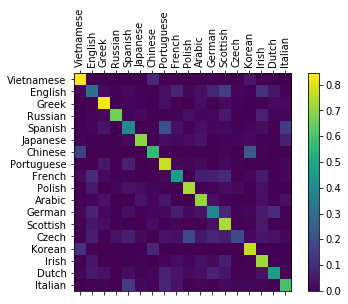

In [14]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    start_time = time.time()

    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
#         print("%",line_tensor[i])
        output, hidden = rnn(line_tensor[i], hidden)
#         print("%", hidden)
    print("--- %s seconds ---" % (time.time() - start_time))
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [15]:

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
#         print(output)
        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
--- 0.0007638931274414062 seconds ---
(-0.62) Russian
(-1.13) Czech
(-2.79) English

> Jackson
--- 0.0007193088531494141 seconds ---
(-0.36) English
(-2.08) Russian
(-2.46) Scottish

> Satoshi
--- 0.0006451606750488281 seconds ---
(-1.30) Italian
(-1.55) Japanese
(-1.74) Arabic


# Exporting the model to onnx and caffe with speed comparison

In [16]:
torch_out = torch.onnx.export(rnn, (lineToTensor('akansha')[0], rnn.initHidden()), 'char_rnn.onnx', export_params=True, verbose=True) # produces the RuntimeError below

graph(%0 : Float(1, 57)
      %1 : Float(1, 128)
      %2 : Float(128, 185)
      %3 : Float(128)
      %4 : Float(18, 185)
      %5 : Float(18)) {
  %6 : Float(1, 185) = onnx::Concat[axis=1](%0, %1), scope: RNN
  %7 : Float(1, 128) = onnx::Gemm[alpha=1, beta=1, transB=1](%6, %2, %3), scope: RNN/Linear[i2h]
  %8 : Float(1, 18) = onnx::Gemm[alpha=1, beta=1, transB=1](%6, %4, %5), scope: RNN/Linear[i2o]
  %9 : Float(1, 18) = onnx::LogSoftmax[axis=1](%8), scope: RNN/LogSoftmax[softmax]
  return (%9, %7);
}



In [17]:
import onnx
import caffe2
import caffe2.python.onnx.backend as onnx_caffe2_backend

# Load the ONNX ModelProto object. model is a standard Python protobuf object

onnx_model = onnx.load("char_rnn.onnx")


In [18]:
# takes array input instead of torch tensor
in1 = lineToTensor('akansha')[0].data.numpy()
in2 = rnn.initHidden().data.numpy()

In [19]:

start_time = time.time()

out, h = caffe2.python.onnx.backend.run_model(onnx_model, [in1, in2])

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.008445978164672852 seconds ---


In [20]:
out  # produces array output instead of torch tensor

array([[-3.0969102, -3.9964178, -4.4682226, -4.081335 , -1.6238663,
        -2.3298087, -3.6378086, -2.0644147, -4.3406234, -2.9473362,
        -2.8546565, -4.23935  , -4.4275675, -1.8626163, -2.8326497,
        -3.6823251, -4.080239 , -2.904221 ]], dtype=float32)

### time taken for rnn run for torch and onnx model

In [21]:
start_time = time.time()

torch_output, h = rnn(lineToTensor('akansha')[0], rnn.initHidden())

print("--- %s seconds ---" % (time.time() - start_time))


--- 0.0014965534210205078 seconds ---


In [22]:

start_time = time.time()

caffe_output, h = caffe2.python.onnx.backend.run_model(onnx_model, [lineToTensor('akansha')[0].data.numpy(), rnn.initHidden().data.numpy()])

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.014128684997558594 seconds ---


In [23]:
torch_output

tensor([[-3.0969, -3.9964, -4.4682, -4.0813, -1.6239, -2.3298, -3.6378, -2.0644,
         -4.3406, -2.9473, -2.8547, -4.2393, -4.4276, -1.8626, -2.8326, -3.6823,
         -4.0802, -2.9042]], grad_fn=<LogSoftmaxBackward>)

In [24]:
caffe_output

array([[-3.0969102, -3.9964178, -4.4682226, -4.081335 , -1.6238663,
        -2.3298087, -3.6378086, -2.0644147, -4.3406234, -2.9473362,
        -2.8546565, -4.23935  , -4.4275675, -1.8626163, -2.8326497,
        -3.6823251, -4.080239 , -2.904221 ]], dtype=float32)

## evaluating on caffe model

In [25]:
def evaluateCaffe2Model(line_tensor):
    start_time = time.time()
    
    hidden_in = rnn.initHidden()
    hidden = hidden_in.data.numpy()
    
    for i in range(line_tensor.size()[0]):
#         print(line_tensor[i])
        input1 = line_tensor[i].data.numpy()
#         print(hidden)
#         print(input1)
#         print(len(input1))
#         print(len(input2))
#         print(input2)
#         print("%",input1)

        output, hidden = caffe2.python.onnx.backend.run_model(onnx_model, [input1, hidden])
#         print("%", hidden)
    print("--- %s seconds ---" % (time.time() - start_time))
    return output

In [26]:
eval_output = evaluateCaffe2Model(lineToTensor('Dovesky'))
eval_output_tensor = torch.from_numpy(eval_output)

--- 0.05469393730163574 seconds ---


In [27]:
eval_output_tensor

tensor([[-10.3794,  -2.7876,  -4.8515,  -0.6234,  -6.8126,  -5.3578,  -8.4976,
          -7.2961,  -4.3989,  -3.8979,  -6.7799,  -5.1645,  -5.4000,  -1.1277,
          -7.4514,  -4.2173,  -5.5728,  -6.9669]])

In [28]:
topv, topi = eval_output_tensor.topk(3, 1, True)
predictions = []

for i in range(3):
    value = topv[0][i].item()
    category_index = topi[0][i].item()
    print('(%.2f) %s' % (value, all_categories[category_index]))
    predictions.append([value, all_categories[category_index]])


(-0.62) Russian
(-1.13) Czech
(-2.79) English


In [29]:
def predictCaffe2Model(input_line, n_predictions=3):
    print('\n> %s' % input_line)
#     with torch.no_grad():
    output = evaluateCaffe2Model(lineToTensor(input_line))
    output = torch.from_numpy(output)
#         print(output)
    # Get top N categories
    topv, topi = output.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predictCaffe2Model('Dovesky')
predictCaffe2Model('Jackson')
predictCaffe2Model('Satoshi')


> Dovesky
--- 0.052504539489746094 seconds ---
(-0.62) Russian
(-1.13) Czech
(-2.79) English

> Jackson
--- 0.02758955955505371 seconds ---
(-0.36) English
(-2.08) Russian
(-2.46) Scottish

> Satoshi
--- 0.022540569305419922 seconds ---
(-1.30) Italian
(-1.55) Japanese
(-1.74) Arabic


The final versions of the scripts `in the Practical PyTorch
repo <https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
split the above code into a few files:

-  ``data.py`` (loads files)
-  ``model.py`` (defines the RNN)
-  ``train.py`` (runs training)
-  ``predict.py`` (runs ``predict()`` with command line arguments)
-  ``server.py`` (serve prediction as a JSON API with bottle.py)

Run ``train.py`` to train and save the network.

Run ``predict.py`` with a name to view predictions:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

Run ``server.py`` and visit http://localhost:5533/Yourname to get JSON
output of predictions.




Exercises
=========

-  Try with a different dataset of line -> category, for example:

   -  Any word -> language
   -  First name -> gender
   -  Character name -> writer
   -  Page title -> blog or subreddit

-  Get better results with a bigger and/or better shaped network

   -  Add more linear layers
   -  Try the ``nn.LSTM`` and ``nn.GRU`` layers
   -  Combine multiple of these RNNs as a higher level network


